# Тестовое задание Junior Data Scientist

Выполнил кандидат: Кудюров Владислав

Использовал датасет на русском языке(corpus вопросов и ответов собирал сам), к датасету длбавил данные  прототипа диалогов,т.к. диалогов не достаточно для  оценки качества модели. Создан список произвольных вопросов из прототипа диалогов.

Архитектуру нейронной сети и параметров подбирал сам.





In [1]:
# Проверем видеокарту
!nvidia-smi

Mon May 24 09:12:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Задание № 1

По ссылке ниже находится документ, в котором приведены примеры 10 реальных диалогов оператора с клиентом. Используя диалоги в качестве прототипа, необходимо создать блок-схему голосового чат-бота, который будет совершать обзвон базы номеров. Ключевой задачей чат-бота является конверсия холодных обзвонов в лидов (передача лида техническому специалисту, который закроет сделку)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.utils import plot_model
import numpy as np 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Flatten 
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import utils 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model 
import yaml 
from matplotlib import pyplot as plt
import random

In [3]:
# Подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загружаем данные и обрабатываем их.

In [4]:
# Открываем файл с диалогами

corpus = open('/content/drive/My Drive/datasets/Диалоги2(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[11906]))

Количество пар вопрос-ответ : 11920
Пример диалога : ['Представляю компанию Электромонтаж.У нас для вас предложение?', 'Слушаю вас.']


In [5]:
# Отделение знаков препинания пробелами
def replaceSigns(s):
    s = s.replace('.', ' . ')
    s = s.replace(',', ' , ')
    s = s.replace('!', ' ! ')
    s = s.replace('?', ' ? ')
    return s.lower()

# Исправленная версия
def strToTokens(sentence: str, maxlen=14): # функция принимает строку на вход (предложение с вопросом)
    words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
    tokensList = tokenizer.texts_to_sequences([words])
    return pad_sequences(tokensList, maxlen=maxlen , padding='post')

# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='Loss на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='Loss на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

# Делает батчи для обучения
class MySequence(Sequence):
    def __init__(self, x_set, y_set, voc_len, batch_size=50):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.voc_len = voc_len

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_z = np.zeros((self.batch_size, batch_y.shape[1], self.voc_len), dtype=np.int32)
        for n in range(self.batch_size):
            for j in range(batch_y.shape[1] - 1):
                batch_z[n, j, batch_y[n, j+1]] = 1
        return [batch_x, batch_y], batch_z

In [6]:
# Тестовые вопросы
myQuestions = [
               'Удобно разговаривать?',
               'У нас для вас предложение?', 
               'Мы помогаем экономить до 40% от суммы расходов на электроэнергию с гарантией результата, интересует?',
               'Скажите, вас заинтересовала бы возможность экономии до 40% расходов на оплату электроенергии?', 
               'Предлагаю детальнее вам ознакомиться с нашим предложением?',
               'Почему?',
               'Разве вам не хотелось бы экономить существенную часть расходов и направить эти средства на что-то более полезное?'
               ]

In [7]:
# Тестирование inference-модели на вопросах
def testModel(encModel, decModel, questions, tokenizer, maxlen):
    for question in questions:
        question = replaceSigns(question)
        statesValues = encModel.predict(strToTokens(question))
        emptyTargetSeq = np.zeros((1, 1))    
        emptyTargetSeq[0, 0] = tokenizer.word_index['start']
        decodedTranslation = ''
        for i in range(maxlen): 
            decOutputs, h, c = decModel.predict([emptyTargetSeq] + statesValues)
            ind = np.argmax(decOutputs, axis=-1)[0, 0]
            if ind == 0:
                break
            sampledWord = tokenizer.index_word[ind]
            if sampledWord == 'end':
                break
            decodedTranslation += (' ' + sampledWord)
            emptyTargetSeq[0, 0] = ind 
            statesValues = [h, c] 
        
        print('Question: ' + question)
        print('Answer: ' + decodedTranslation)

# Для задания расписания для learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [8]:
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[2000]))
print('Ответ : {}'.format(answers[2000]))

Вопрос : Кто? - удивился Славик, - повариха что ли?
Ответ : <START> Ромашка. <END>


In [9]:
# Отделяем знаки препинания от слов
for i, s in enumerate(questions):
    if isinstance(s, list):
        s = s[0]
    questions[i] = replaceSigns(s)

for i, s in enumerate(answers):
    if isinstance(s, list):
        s = s[0]
    answers[i] = replaceSigns(s)

# Добавили oov_token, убрали знаки препинания из фильтра
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n', oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('.', 2), ('start', 3), ('end', 4), ('?', 5), (',', 6), ('что', 7), ('!', 8), ('не', 9), ('я', 10), ('а', 11), ('ты', 12), ('это', 13), ('да', 14), ('в', 15), ('нет', 16), ('как', 17), ('и', 18), ('вы', 19), ('ну', 20), ('с', 21), ('на', 22), ('же', 23), ('так', 24), ('он', 25), ('у', 26), ('кто', 27), ('где', 28), ('все', 29), ('мы', 30), ('то', 31), ('мне', 32), ('тебя', 33), ('меня', 34), ('здесь', 35), ('еще', 36), ('почему', 37), ('о', 38), ('есть', 39), ('там', 40), ('тебе', 41), ('его', 42), ('за', 43), ('куда', 44), ('вот', 45), ('ничего', 46), ('вас', 47), ('знаю', 48), ('чем', 49), ('но', 50)]
Размер словаря : 15163


In [10]:
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions))

Пример оригинального вопроса на вход : какая же мораль ? 
Пример кодированного вопроса на вход : [ 175   23 5731    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11915, 46)
Установленная длина вопросов на вход : 46


In [11]:
# Устанавливаем раскодированные входные данные(ответы)

tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))

Пример оригинального ответа на вход: <start> никакой .  так просто вспомнилось .  <end>
Пример раскодированного ответа на вход : [    3   679     2    24    98 10614     2     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
Размеры раскодированного массива ответов на вход : (11915, 29)
Установленная длина ответов на вход : 29


# Данные готовы к обучению.

In [12]:
# Перемешаем данные
inds = np.array([i for i in range(11900)])
np.random.shuffle(inds)

In [13]:
# Обучающие наборы
x_train = paddedQuestions[inds[:10000]]
y_train = paddedAnswers[inds[:10000]]
x_val = paddedQuestions[inds[10000:10900]]
y_val = paddedAnswers[inds[10000:10900]]
x_test = paddedQuestions[inds[10900:11900]]
y_test = paddedAnswers[inds[10900:11900]]

In [14]:
# сиквенсы для обучения - выдают батчи по 50
seq_train = MySequence(x_train, y_train, voc_len=vocabularySize, batch_size=50)
seq_val = MySequence(x_val, y_val, voc_len=vocabularySize, batch_size=50)
seq_test = MySequence(x_test, y_test, voc_len=vocabularySize, batch_size=50)

# Параметры и протип простенькой модели.

In [15]:
DIM = 200

# Первый входной слой, кодер, выходной слой
encoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет encoderForInput)

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, DIM,  mask_zero=True) (encoderInputs)

# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(DIM, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [16]:
# Второй входной слой, декодер, выходной слой
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, DIM, mask_zero=True) (decoderInputs)

# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(DIM, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)

# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3032600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3032600     input_2[0][0]                    
______________________________________________________________________________________________

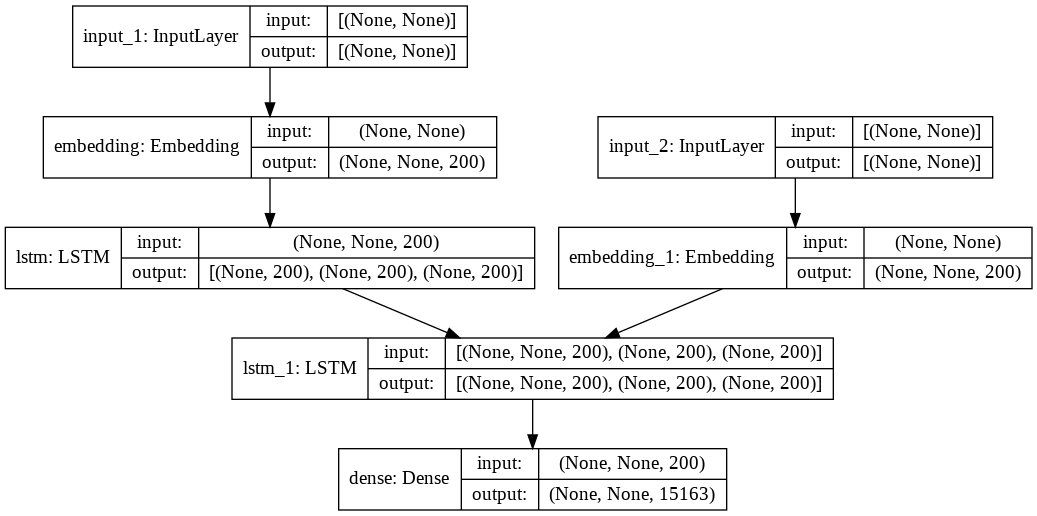

In [17]:
# Собираем тренировочную модель нейросети

model = Model([encoderInputs, decoderInputs], output)
lh = LearnHistory()
print(model.summary())

 # выведем на экран информацию о построенной модели нейросетии построим график для визуализации слоев и связей между ними
plot_model(model, to_file='model.png', show_shapes=True) 

In [18]:
# Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
encoderModel = Model(encoderInputs, encoderStates) 

decoderStateInput_h = Input(shape=(DIM,)) # обозначим размерность для входного слоя с состоянием state_h
decoderStateInput_c = Input(shape=(DIM,)) # обозначим размерность для входного слоя с состоянием state_c

decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

# Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

# Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
# на выходе предсказываемый ответ и новые состояния
decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

# Модель. До и после обучения.

In [19]:
# Необученная модель:
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

Question: удобно разговаривать ? 
Answer:  полюс старину офуна внутренний поселка химобработка друга слегка докладываем спуститься спуститься добрых пару учеба мэйсон бык чучело шмелькову фары антонина улика оставляешь оставляешь разобьем одолжи задразнят облегчением веранде смотрю
Question: у нас для вас предложение ? 
Answer:  пошутить ошибается стреляли гр области области овечьей мясо похороны посходили получить потрогать сердцем пай содержание главное потребовала станем андрюшенька неделю коем капитан хитрый работе тэйлор шевелись тяжелейшие труженик свиты
Question: мы помогаем экономить до 40% от суммы расходов на электроэнергию с гарантией результата ,  интересует ? 
Answer:  демон лава лава заграница распоряжениях точно месте травница травница позавчера замерзли начать родились дачу нажить шампанское доисторических поездку возница сунуть ошиблась письма возвращаться возвращаться возвращаться трусову прийти прийти стефи
Question: скажите ,  вас заинтересовала бы возможность эконо

Epoch 1/50
200/200 [==============================] - 36s 151ms/step - loss: 1.9994 - accuracy: 0.1724 - val_loss: 1.2210 - val_accuracy: 0.1537
Epoch 2/50
200/200 [==============================] - 28s 139ms/step - loss: 1.1934 - accuracy: 0.1619 - val_loss: 1.2050 - val_accuracy: 0.1997
Epoch 3/50
200/200 [==============================] - 28s 139ms/step - loss: 1.1494 - accuracy: 0.2161 - val_loss: 1.1426 - val_accuracy: 0.2738
Epoch 4/50
200/200 [==============================] - 28s 139ms/step - loss: 1.0826 - accuracy: 0.3174 - val_loss: 1.1044 - val_accuracy: 0.3841
Epoch 5/50
200/200 [==============================] - 28s 139ms/step - loss: 1.0271 - accuracy: 0.3913 - val_loss: 1.0748 - val_accuracy: 0.3931
Epoch 6/50
200/200 [==============================] - 28s 139ms/step - loss: 1.0005 - accuracy: 0.3955 - val_loss: 1.0591 - val_accuracy: 0.3947
Epoch 7/50
200/200 [==============================] - 28s 139ms/step - loss: 0.9775 - accuracy: 0.3972 - val_loss: 1.0516 - val_ac

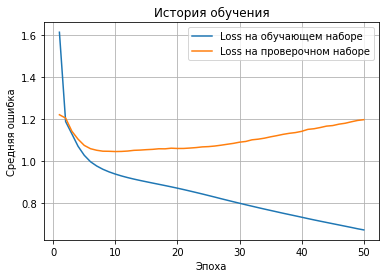

In [20]:
# Обучение на 50 эпохах
model.compile(optimizer=Adam(lr=0.0002), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(seq_train, validation_data=seq_val, epochs=50) 
lh.append(history)
lh.plot()

После 100 эпохах обучения, модель обученная на датасете отвечает на произвольные вопросы из возможных диалогов.

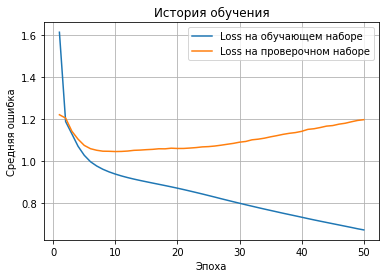

Question: удобно разговаривать ? 
Answer:  э э . . .
Question: у нас для вас предложение ? 
Answer:  да нет .
Question: мы помогаем экономить до 40% от суммы расходов на электроэнергию с гарантией результата ,  интересует ? 
Answer:  я не знаю .
Question: скажите ,  вас заинтересовала бы возможность экономии до 40% расходов на оплату электроенергии ? 
Answer:  да так , товарищ командир !
Question: предлагаю детальнее вам ознакомиться с нашим предложением ? 
Answer:  я не знаю .
Question: почему ? 
Answer:  да , что ты не знаю ?
Question: разве вам не хотелось бы экономить существенную часть расходов и направить эти средства на что-то более полезное ? 
Answer:  да . . .


In [21]:
# После 100 эпох:
lh.plot()
testModel(encoderModel, decoderModel, myQuestions, tokenizer, maxLenAnswers)

In [22]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) 
  decoderStateInput_c = Input(shape=(200 ,)) 
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs)
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel


# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence: str): 
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Устанавливаем окончательные настройки и запускаем модель
encModel, decModel = makeInferenceModels()
for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']
  stopCondition = False 
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax(decOutputs, axis=-1) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3])

Задайте вопрос : привет
 бизнес ! 
Задайте вопрос : есть предложение
 бизнес ! бизнес ! 
Задайте вопрос : купите лампочек


KeyError: ignored

Так как, в данном датасете, не хватает диалогов о предложении и продажах, чат-бот не может ответить корректно на вопросы. Для дальнейшего улучшения ответов или вопрос требуется правильно подобрать корпус с диалогами, а также увеличить колличество эпох обучения  и подборку параметров для снижении ошибки на тестовых вопросах.

# Попробуем усовершенствовать данную модель

In [23]:
#  Наверное наибольшую ценность имеет обучение сети отвечать на произвольные вопросы, для этого надо уменьшать потери на контрольной выборке.
# Разобьем все данные, как положено по феншую, на тренировочные, валидационные и тестовые.

# Перемешаем данные
inds = np.array([i for i in range(11900)])
np.random.shuffle(inds)

In [24]:
# Пересоздадим выборки
x_train = paddedQuestions[inds[:10000]]
y_train = paddedAnswers[inds[:10000]]
x_val = paddedQuestions[inds[10000:10900]]
y_val = paddedAnswers[inds[10000:10900]]
x_test = paddedQuestions[inds[10900:11900]]
y_test = paddedAnswers[inds[10900:11900]]

In [25]:
vocabularySize

15163

In [26]:
# Увеличим размерность векторного (embedding) пространства. Добавим дропауты в LSTM для борьбы с переобучением.
# Перейдем на оптимизатор Adam
DIM = 256

encoderInputs = Input(shape=(None, ))
encoderEmbedding = Embedding(vocabularySize, DIM,  mask_zero=True) (encoderInputs)
encoderOutputs, state_h , state_c = LSTM(DIM, dropout=0.2, recurrent_dropout=0.2, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

decoderInputs = Input(shape=(None, ))
decoderEmbedding = Embedding(vocabularySize, DIM, mask_zero=True) (decoderInputs) 
decoderLSTM = LSTM(DIM, dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

model1 = Model([encoderInputs, decoderInputs], output)
lh = LearnHistory() 
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    3881728     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    3881728     input_8[0][0]                    
____________________________________________________________________________________________

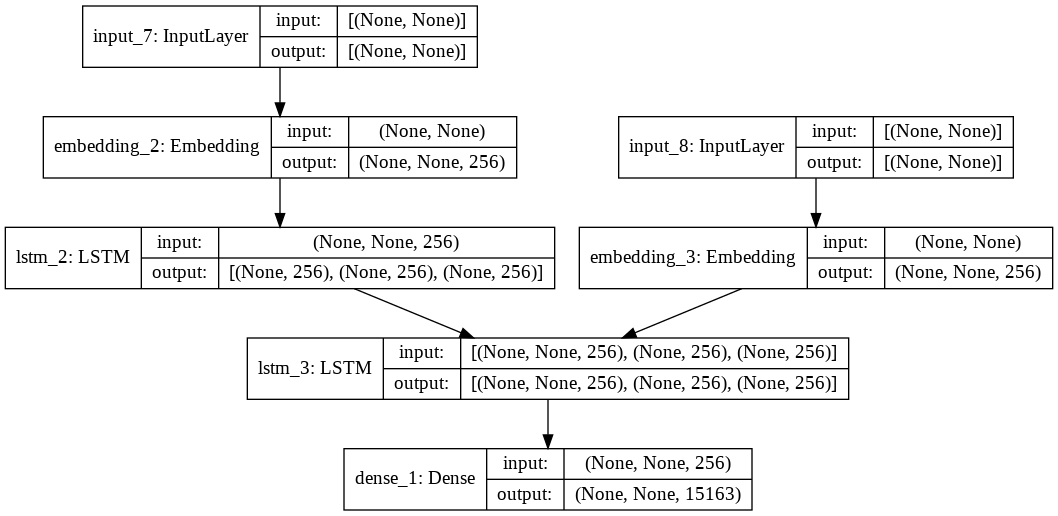

In [27]:
plot_model(model1, to_file='model.png', show_shapes=True)

In [28]:
# Нам нужны 3 сиквенса на каждый тип данных.

seq_train = MySequence(x_train, y_train, voc_len=vocabularySize, batch_size=100)
seq_val = MySequence(x_val, y_val, voc_len=vocabularySize, batch_size=100)
seq_test = MySequence(x_test, y_test, voc_len=vocabularySize, batch_size=100)

Epoch 1/20
100/100 [==============================] - 44s 392ms/step - loss: 1.7078 - accuracy: 0.1974 - val_loss: 1.1999 - val_accuracy: 0.2077
Epoch 2/20
100/100 [==============================] - 38s 384ms/step - loss: 1.1044 - accuracy: 0.3058 - val_loss: 1.0605 - val_accuracy: 0.3933
Epoch 3/20
100/100 [==============================] - 39s 389ms/step - loss: 0.9766 - accuracy: 0.3983 - val_loss: 1.0511 - val_accuracy: 0.4045
Epoch 4/20
100/100 [==============================] - 39s 387ms/step - loss: 0.9315 - accuracy: 0.4110 - val_loss: 1.0617 - val_accuracy: 0.4077
Epoch 5/20
100/100 [==============================] - 39s 386ms/step - loss: 0.9009 - accuracy: 0.4174 - val_loss: 1.0744 - val_accuracy: 0.4120
Epoch 6/20
100/100 [==============================] - 39s 388ms/step - loss: 0.8690 - accuracy: 0.4363 - val_loss: 1.0890 - val_accuracy: 0.4238
Epoch 7/20
100/100 [==============================] - 39s 387ms/step - loss: 0.8484 - accuracy: 0.4527 - val_loss: 1.1020 - val_ac

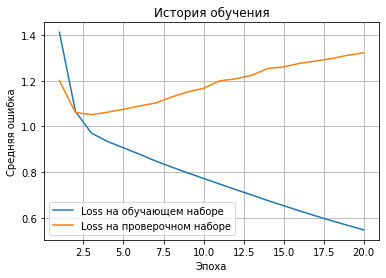

In [29]:
# Пробовал менять lr по расписанию.

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
history = model1.fit(seq_train, validation_data=(seq_val), epochs=20) 
lh.append(history)
lh.plot()


# Выводы:

- Для улучшения качества модели потребуется грамотно составить корпус;
 
- Увеличить колличество эпох.

Создание чат-бота подразумевается, что выходная последовательность должна как-то достаточно однозначно вытекать из входной. Создание чат-бота - скорее задача классификации. Особенность в том, что классов очень много (тысячи). Надо найти в базе запрос, максимально похожий (а лучше совпадающий) с введенным запросом и рандомно выдать один из заготовленных ответов.

Нейронная сеть является универсальным аппроксиматором, и есть теорема, утверждающая, что сеть способна обеспечить любую наперед заданную точность. Но это касается лишь обучаемых данных. Поэтому задача снижения потерь на тренировочных данных не слишком трудна, нужно лишь взять досточно сложную сеть и нужное число эпох. Ценность такого обучения весьма ограничена - сеть лишь запомнит конкретные ответы на конкретные вопросы, но не сможет хорошо отвечать на произвольные вопросы.

Более ценным результатом было бы обучение, дающее малую потерю на тестовом наборе. Однако в нашем случае добиться хорошего результата на тестовом наборе не получилось - несмотря на все предпринятые меры, очень быстро наступало переобучение, а потери оставались на высоком уровне. Я объясняю такой результат тем, что данные в ответах не вытекают логически из вопросов, и довольно произвольны. 

При обучении модели возникли серьезные проблемы с нехваткой памяти, так как OHE кодировка давала огромные массивы, приводившие к краху сессии. Поэтому мне пришлось создать свой сиквенс, выдающий данные в OHE формате батчами лишь по 50 штук. Это решило проблему.


